# Wide and Deep Model to Predict Ad-click Probability
> Training a Tensorflow based Wide and Deep model on criteo sample dataset to predict the probability of ad-click

- toc: true
- badges: true
- comments: true
- categories: [CTR, Tensorflow, WideAndDeep]
- author: "<a href='https://github.com/liangxiaotian/Recommender-Systems'>liangxiaotian</a>"
- image:

## Setup

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Dropout
from tensorflow.keras.experimental import LinearModel, WideDeepModel
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [ ]:
read_part = True
sample_num = 5000000
test_size = 0.2
embed_dim = 8
filename = "criteo_sample.txt"
epochs = 100

## Dataset

dataset：criteo dataset sample

created on July 13, 2020

features：
- Label - Target variable that indicates if an ad was clicked (1) or not (0).
- I1-I13 - A total of 13 columns of integer features (mostly count features).
- C1-C26 - A total of 26 columns of categorical features.
The values of these features have been hashed onto 32 bits for anonymization purposes.

@author: Ziyao Geng(zggzy1996@163.com)

In [ ]:
!wget https://github.com/sparsh-ai/reco-data/raw/master/criteo_sample.txt

In [ ]:
def create_criteo_dataset(filename, embed_dim=8, read_part=True, sample_num=100000, test_size=0.2):
    """
    a example about creating criteo dataset
    :param file: dataset's path
    :param embed_dim: the embedding dimension of sparse features
    :param read_part: whether to read part of it
    :param sample_num: the number of instances if read_part is True
    :param test_size: ratio of test dataset
    :return: feature columns, train, test
    """
    names = ['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11',
             'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
             'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
             'C23', 'C24', 'C25', 'C26']

    if read_part:
        data_df = pd.read_csv(filename, sep='\t', iterator=True, header=None,
                          names=names)
        data_df = data_df.get_chunk(sample_num)

    else:
        data_df = pd.read_csv(filename, sep='\t', header=None, names=names)

    sparse_features = ['C' + str(i) for i in range(1, 27)] 
    dense_features = ['I' + str(i) for i in range(1, 14)]
    features = sparse_features + dense_features

    data_df[sparse_features] = data_df[sparse_features].fillna('-1')
    data_df[dense_features] = data_df[dense_features].fillna(0)

    # Bin continuous data into intervals.
    est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
    data_df[dense_features] = est.fit_transform(data_df[dense_features])

    for feat in sparse_features:
        le = LabelEncoder()
        data_df[feat] = le.fit_transform(data_df[feat])

    # ==============Feature Engineering===================

    # feature_columns = [sparseFeature(feat, int(data_df[feat].max()) + 1, embed_dim=embed_dim)
    #                     for feat in features] # 
    train, test = train_test_split(data_df, test_size=test_size)

    train_X = train[features]# .values.astype('int32')
    train_y = train['label']#.values.astype('int32')
    test_X = test[features]#.values.astype('int32')
    test_y = test['label']#.values.astype('int32')

    return sparse_features, dense_features, (train_X, train_y), (test_X, test_y)

In [ ]:
sparse_features, dense_features, train, test = create_criteo_dataset(filename=filename,
                                                                     embed_dim=embed_dim,
                                                                     read_part=read_part,
                                                                     sample_num=sample_num,
                                                                     test_size=test_size)
train_X, train_y = train
test_X, test_y = test

In [ ]:
train_X.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
6935,8,115,8602,20941,41,5,3767,8,2,9817,2532,11137,1808,17,1376,26703,9,882,150,1,13042,0,1,8921,1,1010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
23178,113,21,9940,3007,23,10,7176,2,2,826,1866,39820,410,25,621,34379,0,911,734,2,20459,8,1,417,41,5382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34557,283,275,2339,425,23,10,5750,86,2,2505,722,8762,2662,2,4525,31537,9,1287,0,0,554,6,1,176,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16012,229,83,31446,10039,23,5,4769,8,2,10845,683,21083,1630,2,1346,13620,9,2408,0,0,35343,0,1,10429,0,0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1.0,0.0,0.0
19677,512,261,20299,16774,23,10,1192,8,2,2180,598,36206,2719,17,3304,25438,9,1856,923,3,24075,0,1,8363,41,3460,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,16.0,1.0,0.0,0.0


In [ ]:
linear_inputs = train_X[sparse_features].values.astype('int32')
dnn_inputs = train_X[dense_features].values.astype('int32')
y = train_y.values.astype('int32')

In [ ]:
test_linear_inputs = test_X[sparse_features].values.astype('int32')
test_dnn_inputs = test_X[dense_features].values.astype('int32')
test_y = test_y.values.astype('int32')

In [ ]:
linear_inputs.shape, dnn_inputs.shape, y.shape

((80000, 26), (80000, 13), (80000,))

## Model

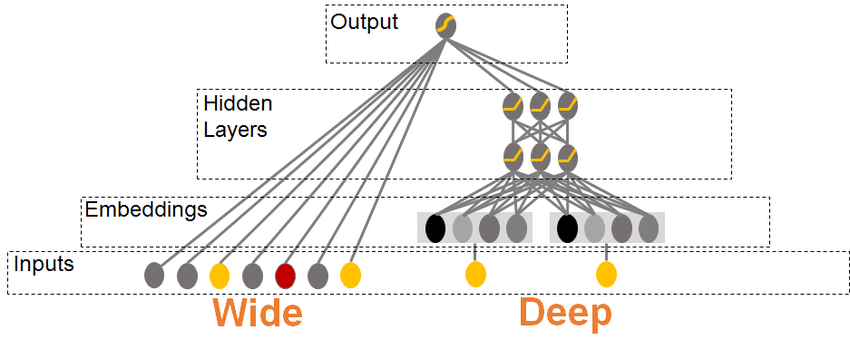

In [ ]:
# wide model
linear_model = LinearModel()

In [ ]:
# deep model
dnn_model = tf.keras.Sequential()
dnn_model.add(tf.keras.layers.Embedding(input_dim=100, output_dim=8, input_length=len(dense_features)))
dnn_model.add(tf.keras.layers.Flatten()) # or concat embedding layers

In [ ]:
dnn_model.add(keras.layers.Dense(units = 256))
dnn_model.add(keras.layers.Dense(units = 128))
dnn_model.add(keras.layers.Dense(units = 64))
dnn_model.add(keras.layers.Dense(units = 1, activation = None))

In [ ]:
combined_model = WideDeepModel(linear_model, dnn_model, activation = 'sigmoid')

In [ ]:
combined_model.compile(optimizer=[Adam(learning_rate=0.0001), Adam(learning_rate=0.0001)], 
                       loss= binary_crossentropy, metrics=[AUC()])

## Training and Validation

In [ ]:
history = combined_model.fit([linear_inputs, dnn_inputs], y, epochs = epochs, batch_size = 4096, validation_split = 0.1)

Epoch 1/100
18/18 [==============================] - 3s 71ms/step - loss: 1.5652 - auc: 0.5056 - val_loss: 0.6777 - val_auc: 0.5440
Epoch 2/100
18/18 [==============================] - 1s 55ms/step - loss: 0.7172 - auc: 0.5079 - val_loss: 0.6692 - val_auc: 0.5291
Epoch 3/100
18/18 [==============================] - 1s 55ms/step - loss: 0.5733 - auc: 0.5173 - val_loss: 0.5363 - val_auc: 0.5591
Epoch 4/100
18/18 [==============================] - 1s 54ms/step - loss: 0.5377 - auc: 0.5437 - val_loss: 0.5330 - val_auc: 0.5648
Epoch 5/100
18/18 [==============================] - 1s 55ms/step - loss: 0.5306 - auc: 0.5701 - val_loss: 0.5312 - val_auc: 0.5755
Epoch 6/100
18/18 [==============================] - 1s 55ms/step - loss: 0.5278 - auc: 0.5857 - val_loss: 0.5280 - val_auc: 0.5923
Epoch 7/100
18/18 [==============================] - 1s 53ms/step - loss: 0.5253 - auc: 0.5975 - val_loss: 0.5280 - val_auc: 0.6210
Epoch 8/100
18/18 [==============================] - 1s 55ms/step - loss: 0.

In [ ]:
combined_model.summary()

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_model (LinearModel)   multiple                  27        
_________________________________________________________________
sequential (Sequential)      (None, 1)                 68897     
Total params: 68,924
Trainable params: 68,924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('test mse: %f' % combined_model.evaluate([test_linear_inputs, test_dnn_inputs], test_y, batch_size=32)[1])

625/625 [==============================] - 2s 2ms/step - loss: 0.4909 - auc: 0.6978
test mse: 0.697828


## Accuracy and Loss Plot

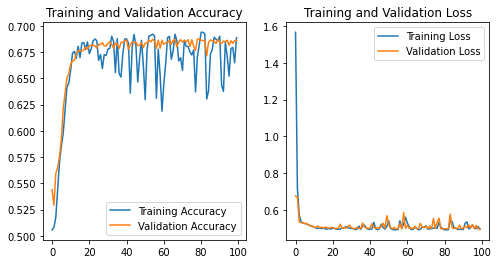

In [ ]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()